In [2]:
import torch
import numpy as np 
import os
import sys
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
from sklearn.datasets import make_swiss_roll, make_moons, make_circles
from lib.lib_lopt import *
from ot.lp.emd_wrap import emd_c, check_result, emd_1d_sorted

In [3]:
n=int(20)
a=np.ones(n)
b=np.ones(n)
X=np.random.rand(n)
Y=np.random.rand(n)
M=cost_matrix(X,Y)
numItermax=12
numThreads=1

#@torch.compile
def test2():
    G, cost, u, v, result_code = emd_c(a, b, M, numItermax, numThreads)
    result_code_string = check_result(result_code)
    return 0

#@nb.jit()
def test():
    G, cost, u, v, result_code = emd_c(a, b, M, numItermax, numThreads)
    result_code_string = check_result(result_code)
    return 0




In [4]:
%time test2()
%time test()

CPU times: user 109 µs, sys: 152 µs, total: 261 µs
Wall time: 269 µs
CPU times: user 113 µs, sys: 159 µs, total: 272 µs
Wall time: 174 µs


/tmp/ipykernel_2081240/1873500357.py:13: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 12. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually have the correct solution, if not try setting the maximum number of iterations a bit higher
/tmp/ipykernel_2081240/1873500357.py:19: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
RESULT MIGHT BE INACURATE
Max number of iteration reached, currently 12. Sometimes iterations go on in cycle even though the solution has been reached, to check if it's the case here have a look at the minimal reduced cost. If it is very close to machine precision, you might actually 

0

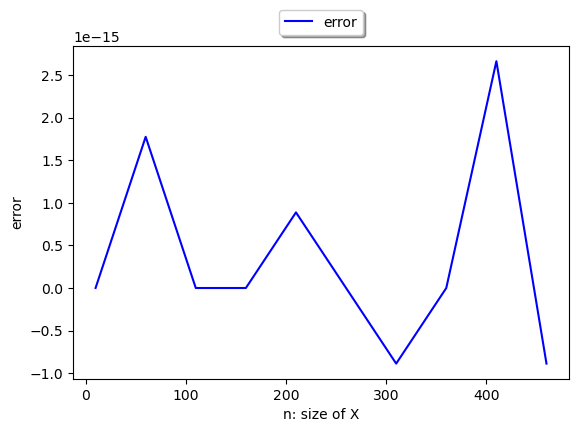

In [48]:
# test correctness
Lambda=5.0
step_size=50
k=1
n_list=np.array(range(10,500,step_size))

opt_cost1=np.zeros((n_list.shape[0],k))
opt_cost2=np.zeros((n_list.shape[0],k))

for i in range(n_list.shape[0]):
    n=n_list[i]
    for k_p in range(k):
        X0=np.random.uniform(-20,20,(n,2))+15
        X1=np.random.uniform(-20,20,(n,2))+0
        X2=np.random.uniform(-20,20,(n,2))+30

        p0=np.ones(n)/n
        p1=np.ones(n)/n
        p2=np.ones(n)/n
        cost1,gamma,penualty1=opt_lp(X0,X1,p0,p1,Lambda,numItermax=200000)
        opt_cost1[i,k_p]=cost1+penualty1
        U0=np.zeros((n,2))
        M0=0.0
        p0_hat=p0
        U1,p1_hat,M1,p1Perp=lopt_embedding(X0,X1,p0,p1,Lambda)
        cost2,penualty2=lopt(U1,U0,p1_hat,p0_hat,Lambda,M1,M0)
#        cost2=np.sum((U1.T)**2*p1_hat)
#        penualty2=Lambda*(np.sum(np.abs(p0-p1_hat))+M1)
        
        opt_cost2[i,k_p]=cost2+penualty2

#        Vi,p0_Ti=linear_embedding(Xi,X0,p1,p0,Lambda)
#        Vj,p0_Tj=linear_embedding(Xj,X0,p2,p0,Lambda)
#        Vij,p0_Tij=vector_plus(Vi,-Vj,p0_Ti,p0_Tj)
#        cost2,penualty2=vector_norm(Vij,p0_Tij,1,Lambda)
#        opt_cost2[i,k_p]=cost2+penualty2
        # if cost2+penualty2<cost1+penualty1-0.00001:
            #     print('error')
            #     print('cost2',cost2)
    #     print('cost1',cost1)
    #     print('penualty1',penualty1)
    #     print('penualty2',penualty2)
    #     break



fig = plt.figure()
ax = plt.subplot(111)
error=opt_cost2-opt_cost1
error_mean=error.mean(1)
error_std=error.std(1)

plt.plot(n_list,error_mean,'-',c='blue',label='error')
plt.fill_between(n_list,error_mean-1*error_std,error_mean+1*error_std,alpha=0.3)

plt.xlabel("n: size of X")
plt.ylabel("error")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.13),
          fancybox=True, shadow=True, ncol=3)
#plt.savefig('experiment/test/results/accuracy_error'+str(Lambda)+'.png',format="png",dpi=800,bbox_inches='tight')
plt.show()


In [42]:

step_size=50

l=5
K_list=[2,4]
n_list=np.array([500]) # np.array(range(200,1050,step_size))

m_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

id2=np.eye(2)
Lambda_list=np.linspace(0.2,30,30)
Lambda_N=Lambda_list.shape[0]
save_dict={}

    
for K in K_list:
    List_ij=[]
    for i in range(K):
        for j in range(i+1,K):
            List_ij.append((i,j))
    n_compute=len(List_ij)
    opt_cost1=np.zeros((n_list.shape[0],Lambda_N,l,n_compute))
    opt_cost2=np.zeros((n_list.shape[0],Lambda_N,l,n_compute))
    opt_cost3=np.zeros((n_list.shape[0],Lambda_N,l,n_compute))
    for Lambda_i,Lambda in enumerate(Lambda_list):
        print('Lambda',Lambda)
        
        #save_dict['Lambda'+str(Lambda)]={}
        for epoch,n in enumerate(n_list):
            print('n',n)
            for l_p in range(l):
                #generate data
                X_list=list()
                p_list=list()
                for i in range(K):
                    vi=m_list[i]
                    Xi=np.random.multivariate_normal(vi,id2,n)
                    X_list.append(Xi)    
                    p_list.append(np.ones(n))
                X_list=np.stack(X_list)
                p_list=np.stack(p_list)
                m_bar=np.mean(m_list,0)
                p0=np.ones(n)

                # compute OPT distance pairwisely 
                for k in range(n_compute):
                    i,j=List_ij[k]
                    X1=X_list[i]
                    X2=X_list[j]
                    p1=p_list[i]
                    p2=p_list[j]          
                    cost1,plan1,penualty1=opt_lp(X1,X2,p1,p2,Lambda,numItermax=1000*n)
                    opt_cost1[epoch,Lambda_i,l_p,k]=cost1+penualty1

                # compute lopt embedding
                X01=np.random.multivariate_normal(m_bar,id2,n)
                opt_embedding_list1=[]

                for i in range(K):
                    Xi=X_list[i]
                    pi=p_list[i]
                    Ui,pi_hat,Mi,pi_perp=lopt_embedding(X01,Xi,p0,pi,Lambda,numItermax=1000*n)
                    opt_embedding_list1.append((Ui,pi_hat,Mi))
                for k in range(n_compute):
                    i,j=List_ij[k]
                    Ui,pi_hat,Mi=opt_embedding_list1[i]
                    Uj,pj_hat,Mj=opt_embedding_list1[j]
                    cost2,penualty2=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                    opt_cost2[epoch,Lambda_i,l_p,k]=cost2+penualty2

                # # compute the lopt embedding by barycenter 
                # X_init=X01
                # weights=np.ones(K)/K
                # X02=X01.copy()
                # X02=lot_barycenter(X_list, p_list, X_init, p0, weights, numItermax=50,numItermax_LP=1000*n,stopThr=1e-4)
                # opt_embedding_list2=list()
                # for i in range(K):
                #     Xi=X_list[i]
                #     pi=p_list[i]
                #     Ui,pi_hat,Mi=lopt_embedding(X02,Xi,p0,pi,Lambda,numItermax=1000*n)
                #     opt_embedding_list2.append((Ui,pi_hat,Mi))
                # for k in range(n_compute):
                #     i,j=List_ij[k]
                #     Ui,pi_hat,Mi=opt_embedding_list2[i]
                #     Uj,pj_hat,Mj=opt_embedding_list2[j]
                #     cost3,penualty3=lopt(Ui,Uj,pi_hat,pj_hat,Lambda,Mi,Mj)
                #     opt_cost3[epoch,l_p,k]=cost3+penualty3
        save_dict['K=%d,opt_cost1'%(K)]=opt_cost1
        save_dict['K=%d,opt_cost2'%(K)]=opt_cost2
        #save_dict['K=%d,opt_cost3'%(K)]=opt_cost3
torch.save(save_dict,'experiment/performance/cost_list.pt')

Lambda 0.2
n 500
Lambda 1.2275862068965517
n 500
Lambda 2.2551724137931037
n 500
Lambda 3.2827586206896555
n 500
Lambda 4.310344827586207
n 500
Lambda 5.337931034482759
n 500
Lambda 6.365517241379311
n 500
Lambda 7.393103448275863
n 500
Lambda 8.420689655172414
n 500
Lambda 9.448275862068964
n 500
Lambda 10.475862068965517
n 500
Lambda 11.50344827586207
n 500
Lambda 12.53103448275862
n 500
Lambda 13.558620689655172
n 500
Lambda 14.586206896551724
n 500
Lambda 15.613793103448277
n 500
Lambda 16.641379310344828
n 500
Lambda 17.66896551724138
n 500
Lambda 18.69655172413793
n 500
Lambda 19.724137931034484
n 500
Lambda 20.751724137931035
n 500
Lambda 21.779310344827586
n 500
Lambda 22.80689655172414
n 500
Lambda 23.83448275862069
n 500
Lambda 24.862068965517242
n 500
Lambda 25.889655172413793
n 500
Lambda 26.917241379310344
n 500
Lambda 27.944827586206898
n 500
Lambda 28.97241379310345
n 500
Lambda 30.0
n 500
Lambda 0.2
n 500
Lambda 1.2275862068965517
n 500
Lambda 2.2551724137931037
n 500
L

K 2
K 4


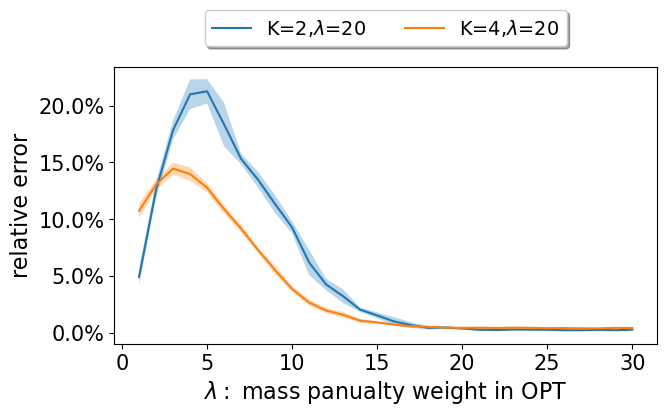

done


In [41]:
#save_dict=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
linestyle_array = ['-', '-', '--', '--', '-.', '-.']
Lambda_list=np.linspace(1,30,30)
m_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

#ax = plt.subplot(111)
save_dict2=torch.load('experiment/performance/cost_list.pt')

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)
ind=0
for K in [2,4]:
    print('K',K)
    opt_cost1=save_dict2['K=%d,opt_cost1'%(K)]
    opt_cost2=save_dict2['K=%d,opt_cost2'%(K)]
    relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(3)[0]
    relative_error_mean=relative_error.mean(1)
    relative_error_std=relative_error.std(1)
    ax.plot(Lambda_list,relative_error_mean,linestyle_array[ind],label=r'K=%d'%(K))
    ax.fill_between(Lambda_list,relative_error_mean-1*relative_error_std,relative_error_mean+1*relative_error_std,alpha=0.3)
    ind+=1

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_xlabel("$\lambda:$ mass panualty weight in OPT",fontsize=16)
ax.set_ylabel("relative error",fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.24),
          fancybox=True, shadow=True, ncol=3,fontsize=13.9)
plt.savefig('experiment/performance/error%d.pdf'%(x),format="pdf",dpi=800,bbox_inches='tight')
plt.show()
#plt.close()

print('done')

K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


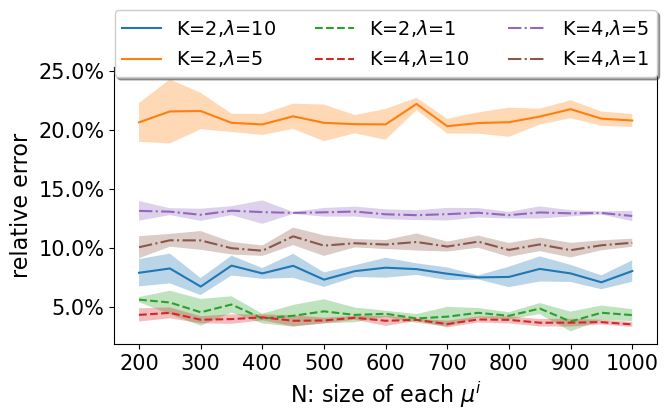

done
K, 2
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0
K, 4
Lambda, 10.0
Lambda, 5.0
Lambda, 1.0


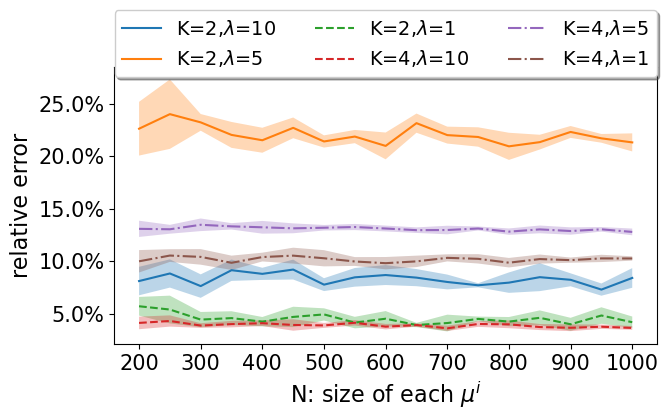

done


In [61]:
#save_dict=torch.load('experiment/performance/cost_list_K'+str(K)+ '.pt')
linestyle_array = ['-', '-', '--', '--', '-.', '-.']
Lambda=20.0
step_size=50

l=5
K_list=[2,4]
n_list=np.array(range(200,1050,step_size))

m_list=np.array([[1.,1.],[-1.,-1.],[-1.,1.],[1.,-1.]])

id2=np.eye(2)
Lambda_list=[10.0,5.0,1.0]
save_dict={}
#ax = plt.subplot(111)
save_dict2=torch.load('experiment/performance/cost_list.pt')
for x in [2,3]:
    fig = plt.figure(1, (7,4))
    ax = fig.add_subplot(1,1,1)
    ind=0
    for K in [2,4]:
        print('K,',K)
        for Lambda in Lambda_list:
            print('Lambda,',Lambda)
            opt_cost1=save_dict2['Lambda=%d,K=%d,opt_cost1'%(Lambda,K)]
            opt_cost2=save_dict2['Lambda=%d,K=%d,opt_cost%d'%(Lambda,K,x)]
            relative_error=(np.abs(opt_cost2-opt_cost1)/opt_cost1).mean(2)
            relative_error_mean=relative_error.mean(1)
            relative_error_std=relative_error.std(1)

            #label=r'K=%d,$\lambda$=%d'%(K,Lambda)
            ax.plot(n_list,relative_error_mean,linestyle_array[ind],label=r'K=%d,$\lambda$=%d'%(K,Lambda))
            ax.fill_between(n_list,relative_error_mean-1*relative_error_std,relative_error_mean+1*relative_error_std,alpha=0.3)
            ind+=1
   
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) 
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_xlabel("N: size of each $\mu^i$",fontsize=16)
    ax.set_ylabel("relative error",fontsize=16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,box.width, box.height * 0.9])
    ax.legend(loc='upper center',bbox_to_anchor=(0.5, 1.24),
              fancybox=True, shadow=True, ncol=3,fontsize=13.9)
    plt.savefig('experiment/performance/error%d.pdf'%(x),format="pdf",dpi=800,bbox_inches='tight')
    plt.show()
    #plt.close()
    
    print('done')